In [1]:
import re
import os
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
import seaborn as sns
import numpy as np
from IPython.display import HTML

In the first pass, we do a rough tokenization of the authentication log. We don't actually know how many different 'auth_source' types to expect, so we need to do some analysis to understand this better.

**Note: moved Dec 22, 2020, set up ssh port-forwarding on Jan 28, 2021**
**Note: logs were lost before Feb 2021 because I upgraded my Ubuntu system. I also disabled password authentication at this  time, leaving only key-based authentication to increase security.**

# Read the logs and do first coarse parsing

In [2]:
auth_parse = '^([A-Z][a-z]{2} [0-9\ ]\d \d{2}:\d{2}:\d{2}) ([a-z0-9A-Z][a-zA-Z0-9-]{0,62}) ([^:]+): (.*)$'
auth = []
with open("./all_auth_logs.txt") as f:
  lines = f.readlines()
  for line in lines:
    m = re.findall(auth_parse, line)
    auth_d = {
      'timestamp': dt.datetime.strptime(m[0][0], '%b %d %H:%M:%S').replace(year=2020),
      'hostname': m[0][1],
      'auth_source': m[0][2],
      'message': m[0][3]
    }
    auth.append(auth_d)

In [3]:
df = pd.DataFrame(auth)
df['auth_type'] = ''
df['auth_pid'] = -1

In [4]:
df

,timestamp,hostname,auth_source,message,auth_type,auth_pid
0,2020-04-23 07:57:52,computer,sudo,root : TTY=unknown ; PWD=/ ; USER=bdogg ; ...,,-1
1,2020-04-23 07:57:52,computer,sudo,pam_unix(sudo:session): session opened for use...,,-1
2,2020-04-23 07:57:52,computer,gdm-launch-environment],pam_unix(gdm-launch-environment:session): sess...,,-1
3,2020-04-23 07:57:52,computer,systemd-logind[1007],New session c1 of user gdm.,,-1
4,2020-04-23 07:57:52,computer,systemd,pam_unix(systemd-user:session): session opened...,,-1
...,...,...,...,...,...,...
15259,2020-02-14 15:35:46,computer,systemd-logind[751],Watching system buttons on /dev/input/event0 (...,,-1
15260,2020-02-14 15:35:46,computer,sudo,root : TTY=unknown ; PWD=/ ; USER=bdogg ; ...,,-1
15261,2020-02-14 15:35:46,computer,sudo,pam_unix(sudo:session): session opened for use...,,-1
15262,2020-02-14 15:35:46,computer,sshd[931],Server listening on 0.0.0.0 port 22.,,-1


# Parse out the different auth sources

In [7]:
ssh_idx = df['auth_source'].str.startswith('sshd')
df.loc[ssh_idx, 'auth_type'] = 'ssh'
df.loc[ssh_idx, 'auth_pid'] = df.loc[ssh_idx, 'auth_source'].apply(lambda x: re.findall('sshd\[(\d+)\]',x)[0])

cron_idx = df['auth_source'].str.startswith('CRON')
df.loc[cron_idx, 'auth_type'] = 'cron'
df.loc[cron_idx, 'auth_pid'] = df.loc[cron_idx, 'auth_source'].apply(lambda x: re.findall('CRON\[\d+\]', x)[0])

login_idx = df['auth_source'].str.startswith('systemd-logind')
df.loc[login_idx, 'auth_type'] = 'physical_login'
df.loc[login_idx, 'auth_pid'] = df.loc[login_idx, 'auth_source'].apply(lambda x: re.findall('systemd-logind\[(\d+)\]', x)[0])

gnome_keyring = df['auth_source'].str.startswith('gnome-keyring-daemon')
df.loc[gnome_keyring, 'auth_type'] = 'gnome_keyring'
df.loc[gnome_keyring, 'auth_pid'] = df.loc[gnome_keyring, 'auth_source'].apply(lambda x: re.findall('gnome-keyring-daemon\[(\d+)\]', x)[0])

pkexec = df['auth_source'].str.startswith('pkexec')
df.loc[pkexec, 'auth_type'] = 'pkexec'

systemd = df['auth_source'].str.startswith('systemd')
df.loc[systemd, 'auth_type'] = 'physical_login'

polkitid = df['auth_source'].str.startswith('polk')
df.loc[polkitid, 'auth_type'] = 'polk'

gdm_password = df['auth_source'].str.startswith('gdm-password')
df.loc[gdm_password, 'auth_type'] = 'gdm_pass'

sudo = df['auth_source'].str.startswith('sudo')
df.loc[sudo, 'auth_type'] = 'sudo'

sudo = df['auth_source'].str.startswith('dbus')
df.loc[sudo, 'auth_type'] = 'dbus'

gdm = df['auth_source'].str.startswith('gdm-launch-env')
df.loc[gdm, 'auth_type'] = 'gdm-launch'

su = df['auth_source'].str.startswith('su[')
df.loc[su, 'auth_type'] = 'switch_user'

df.loc[df['auth_type'] == '', 'auth_type'] = 'other'

df.loc[df['auth_source'].str.startswith('ssh'), 'auth_source'] = 'ssh'
df.loc[df['auth_source'].str.startswith('systemd-logind'), 'auth_source'] = 'systemd-logind'

In [8]:
df

,timestamp,hostname,auth_source,message,auth_type,auth_pid
0,2020-04-23 07:57:52,computer,sudo,root : TTY=unknown ; PWD=/ ; USER=bdogg ; ...,sudo,-1
1,2020-04-23 07:57:52,computer,sudo,pam_unix(sudo:session): session opened for use...,sudo,-1
2,2020-04-23 07:57:52,computer,gdm-launch-environment],pam_unix(gdm-launch-environment:session): sess...,gdm-launch,-1
3,2020-04-23 07:57:52,computer,systemd-logind,New session c1 of user gdm.,physical_login,1007
4,2020-04-23 07:57:52,computer,systemd,pam_unix(systemd-user:session): session opened...,physical_login,-1
...,...,...,...,...,...,...
15259,2020-02-14 15:35:46,computer,systemd-logind,Watching system buttons on /dev/input/event0 (...,physical_login,751
15260,2020-02-14 15:35:46,computer,sudo,root : TTY=unknown ; PWD=/ ; USER=bdogg ; ...,sudo,-1
15261,2020-02-14 15:35:46,computer,sudo,pam_unix(sudo:session): session opened for use...,sudo,-1
15262,2020-02-14 15:35:46,computer,ssh,Server listening on 0.0.0.0 port 22.,ssh,931


# Parse the interesting stuff - ssh

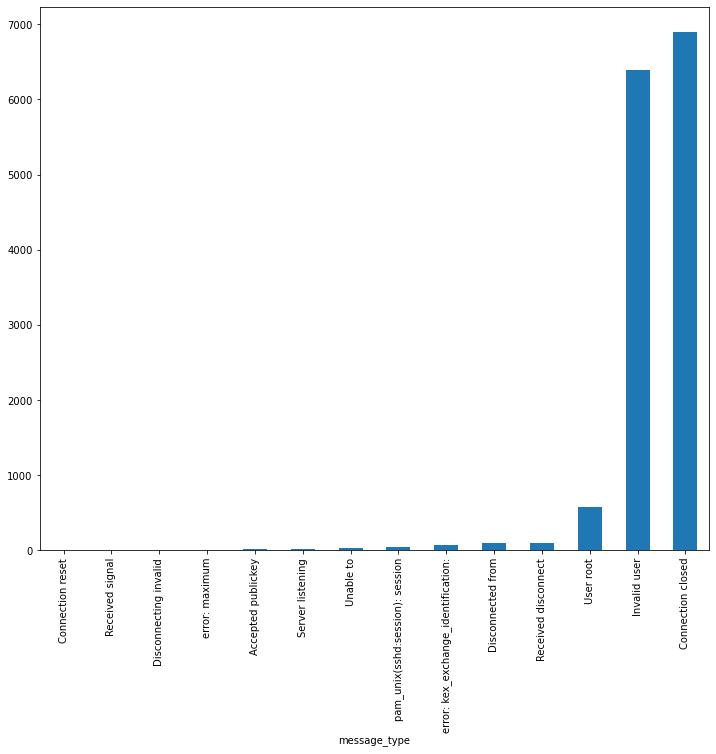

In [10]:
# Get a sense for the message types:
ssh_df = df[df['auth_type'] == 'ssh'].copy(deep=True)
ssh_df['message_type'] = ssh_df['message'].apply(lambda x: ' '.join(x.split(' ')[0:2]))
fig, ax = plt.subplots(figsize=(12, 10))
ssh_df.groupby('message_type').count()['hostname'].sort_values().plot.bar(ax=ax)

In [11]:
ssh_df['message_type'].value_counts() / ssh_df['message_type'].value_counts().sum()

Connection closed                      0.484091
Invalid user                           0.449322
User root                              0.040598
Received disconnect                    0.006813
Disconnected from                      0.006813
error: kex_exchange_identification:    0.004425
pam_unix(sshd:session): session        0.002529
Unable to                              0.001616
Accepted publickey                     0.001264
Server listening                       0.001264
Disconnecting invalid                  0.000562
error: maximum                         0.000562
Connection reset                       0.000070
Received signal                        0.000070
Name: message_type, dtype: float64

In [12]:
# Show successful logins for ssh
set(ssh_df[ssh_df['message'].str.startswith('Accepted')]['message'].apply(lambda x: x.split()[5]))

{'192.168.86.1', '70.187.145.191'}

In [15]:
ssh_df['message']

126                       Received signal 15; terminating.
127                   Server listening on 0.0.0.0 port 22.
128                        Server listening on :: port 22.
137                   Server listening on 0.0.0.0 port 22.
138                        Server listening on :: port 22.
                               ...                        
15245    Accepted publickey for bdogg from 70.187.145.1...
15246    pam_unix(sshd:session): session opened for use...
15255    pam_unix(sshd:session): session closed for use...
15262                 Server listening on 0.0.0.0 port 22.
15263                      Server listening on :: port 22.
Name: message, Length: 14237, dtype: object

In [24]:
ssh_df[ssh_df.message_type == 'Invalid user'].message

224      Invalid user admin from 201.212.210.194 port 5...
226      Invalid user admin from 201.212.210.194 port 5...
228      Invalid user admin from 201.212.210.194 port 5...
230      Invalid user admin from 201.212.210.194 port 5...
232      Invalid user admin from 201.212.210.194 port 5...
                               ...                        
15220        Invalid user demo from 156.0.213.43 port 1700
15222        Invalid user demo from 156.0.213.43 port 9053
15224       Invalid user demo from 156.0.213.43 port 27133
15226       Invalid user demo from 156.0.213.43 port 17138
15228       Invalid user demo from 156.0.213.43 port 11034
Name: message, Length: 6397, dtype: object

Looks like its working - lets pull out all failed login attempts and understand what's going on here.

In [30]:
fail_df = ssh_df[ssh_df.message_type == "Invalid user"].copy(deep=True)

print(re.search("Invalid user (.*) from .*", fail_df.message[224]).group(1))
print(re.search("Invalid user .* from (.*) port .*", fail_df.message[224]).group(1))
print(re.search("Invalid user .* from .* port (.*)", fail_df.message[224]).group(1))

admin
201.212.210.194
51022


In [35]:
fail_df['user_attempt'] = "ERROR" 
fail_df['source_ip'] = "ERROR" 
fail_df['destination_port'] = "ERROR" 
fail_df['user_attempt'] = fail_df.message.apply(lambda x: re.search("Invalid user (.*) from .*", x).group(1))
fail_df['source_ip'] = fail_df.message.apply(lambda x: re.search("Invalid user .* from (.*) port .*", x).group(1))
fail_df['destination_port'] = fail_df.message.apply(lambda x: re.search("Invalid user .* from .* port (.*)", x).group(1))

In [40]:
fail_df['unixtime'] = fail_df['timestamp'].apply(lambda x: time.mktime(x.timetuple()))

In [42]:
fail_df['user_attempt'].value_counts()[fail_df['user_attempt'].value_counts() > 6]

admin            493
default          476
profile1         469
admin1           469
user1            465
user             464
MikroTik         463
web              459
ubnt             455
administrator    455
support          439
tech             428
demo             420
telecomadmin     402
pi                14
Name: user_attempt, dtype: int64

In [46]:
# Pagate and view
rollover = 15

logins = (fail_df['user_attempt'].value_counts()
  .sort_index()
  .reset_index()
  .rename(columns={'index':'login', 'user_attempt':'number'})
)

start_idx = 0
end_idx = rollover

pagated = []

while start_idx < len(logins):
  pagated.append(logins[start_idx:end_idx].reset_index().loc[:,['login', 'number']])
  start_idx += rollover
  end_idx += rollover
  
HTML(pd.concat(pagated, axis=1).to_html())

,login,number,login,number,login,number
0,,5,nvidia,1,user1,465.0
1,MikroTik,463,odroid,1,vicidiem,1.0
2,admin,493,operator,1,vyatta,1.0
3,admin1,469,oracle,1,vyos,1.0
4,administrator,455,orangepi,1,web,459.0
5,bananapi,1,osmc,1,xbian,1.0
6,cablecom,1,pi,14,NaN,NaN
7,debian,1,profile1,469,NaN,NaN
8,default,476,rock64,1,NaN,NaN
9,demo,420,support,439,NaN,NaN


In [48]:
fail_df_summary = pd.concat(
  [
    fail_df[['source_ip', 'destination_port']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'destination_port':'num_destination_ports_scanned'}),
    fail_df[['source_ip', 'timestamp']].groupby('source_ip').max().rename(columns={'timestamp':'max_timestamp'}),
    fail_df[['source_ip', 'timestamp']].groupby('source_ip').min().rename(columns={'timestamp':'min_timestamp'}),
    fail_df[['source_ip', 'timestamp']].groupby('source_ip').count().rename(columns={'timestamp':'number_of_attempts'}),
    fail_df[['source_ip', 'user_attempt']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'user_attempt':'uname_count'}),
    fail_df[['source_ip', 'timestamp']].groupby('source_ip').agg(lambda x: list(x)).rename(columns={'timestamp':'timeseries'}),
    fail_df[['source_ip', 'unixtime']].groupby('source_ip').min().rename(columns={'unixtime':'min_unixtime'}),
    fail_df[['source_ip', 'unixtime']].groupby('source_ip').max().rename(columns={'unixtime':'max_unixtime'}),
    fail_df[['source_ip', 'unixtime']].groupby('source_ip').agg(lambda x: list(x)).rename(columns={'unixtime':'unixtime_timeseries'})
  ],
  axis=1
)
fail_df_summary['ats'] = fail_df_summary['number_of_attempts'] / (fail_df_summary['max_unixtime'] - fail_df_summary['min_unixtime'])
fail_df_summary.sort_values(by='number_of_attempts', ascending=False).head(10)

,num_destination_ports_scanned,max_timestamp,min_timestamp,number_of_attempts,uname_count,timeseries,min_unixtime,max_unixtime,unixtime_timeseries,ats
source_ip,,,,,,,,,,
36.65.245.94,278,2020-03-04 21:35:27,2020-03-04 20:31:43,280,14,"[2020-03-04 20:31:43, 2020-03-04 20:31:51, 202...",1.583354e+09,1.583358e+09,"[1583353903.0, 1583353911.0, 1583353920.0, 158...",0.073222
84.71.190.227,278,2020-03-06 03:39:11,2020-03-06 03:04:05,280,14,"[2020-03-06 03:04:05, 2020-03-06 03:04:12, 202...",1.583464e+09,1.583466e+09,"[1583463845.0, 1583463852.0, 1583463859.0, 158...",0.132953
201.212.210.194,276,2020-04-23 19:05:13,2020-04-23 18:18:52,280,14,"[2020-04-23 18:18:52, 2020-04-23 18:18:59, 202...",1.587666e+09,1.587669e+09,"[1587665932.0, 1587665939.0, 1587665947.0, 158...",0.100683
111.88.95.228,274,2020-02-15 13:56:59,2020-02-15 13:17:20,280,14,"[2020-02-15 13:17:20, 2020-02-15 13:17:27, 202...",1.581773e+09,1.581775e+09,"[1581772640.0, 1581772647.0, 1581772655.0, 158...",0.117697
200.88.165.106,280,2020-04-24 14:13:52,2020-04-24 13:40:28,280,14,"[2020-04-24 13:40:28, 2020-04-24 13:40:34, 202...",1.587736e+09,1.587738e+09,"[1587735628.0, 1587735634.0, 1587735641.0, 158...",0.139721
115.75.65.78,278,2020-03-04 01:09:53,2020-03-04 00:33:06,280,14,"[2020-03-04 00:33:06, 2020-03-04 00:33:13, 202...",1.583282e+09,1.583284e+09,"[1583281986.0, 1583281993.0, 1583282001.0, 158...",0.126869
117.5.147.61,280,2020-02-15 11:30:17,2020-02-15 10:33:50,280,14,"[2020-02-15 10:33:50, 2020-02-15 10:34:03, 202...",1.581763e+09,1.581766e+09,"[1581762830.0, 1581762843.0, 1581762856.0, 158...",0.082669
123.24.176.118,280,2020-02-07 23:42:08,2020-02-07 23:03:22,280,14,"[2020-02-07 23:03:22, 2020-02-07 23:03:30, 202...",1.581117e+09,1.581119e+09,"[1581116602.0, 1581116610.0, 1581116618.0, 158...",0.120378
125.160.227.157,279,2020-02-15 00:19:40,2020-02-14 23:43:13,280,14,"[2020-02-14 23:43:13, 2020-02-14 23:43:20, 202...",1.581724e+09,1.581726e+09,"[1581723793.0, 1581723800.0, 1581723807.0, 158...",0.128029


In [49]:
!pip install ipwhois

In [51]:
from ipwhois import IPWhois
import os
import sys
import numpy as np
import time
import json

ip_country = {}

for ip in fail_df_summary.index.unique():
  try:
    with open("ip_to_country_mapping.json", "r") as f:
      ip_country = json.load(f)
  except:
    pass
  if ip not in ip_country:
    print("processing", ip, "            ", end='\r')
    resp = IPWhois(ip)
    country = resp.lookup_whois()['asn_country_code']
    ip_country[ip] = country
    with open("ip_to_country_mapping.json", "w") as f:
      json.dump(ip_country, f)
    
print("Done")


Doneessing 95.47.250.20                


In [53]:
fail_df_summary['country'] = pd.Series(ip_country)

Text(0.5, 1.0, 'Attacks by Country')

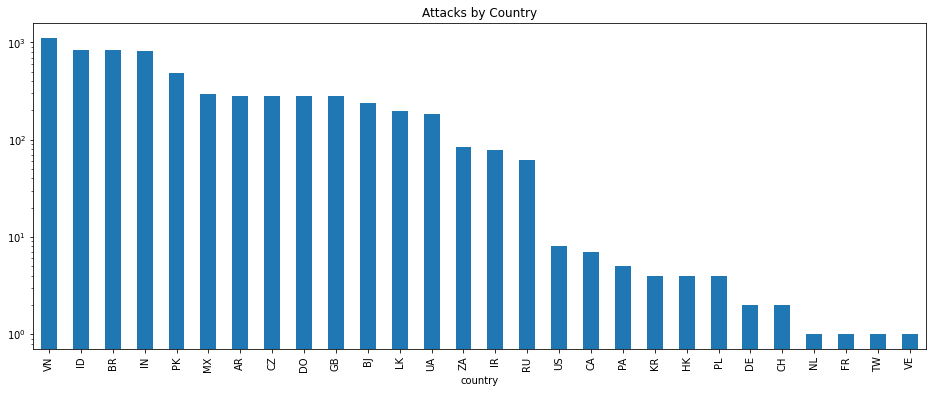

In [54]:
fig, ax = plt.subplots(figsize=(16,6))
fail_df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False).plot.bar(ax=ax, logy=True)
ax.set_title("Attacks by Country")

In [55]:
top_9 = fail_df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False)
top_9 = top_9[:9]

In [56]:
# plt_df = df_summary.loc[df_summary.index == '218.92.0.205']
countries = list(top_9.index)

In [57]:
print(countries, len(countries))

@mpl.ticker.FuncFormatter
def major_formatter(x, pos):
  return dt.datetime.utcfromtimestamp(x).strftime('%Y-%b-%d')


['VN', 'ID', 'BR', 'IN', 'PK', 'MX', 'AR', 'CZ', 'DO'] 9


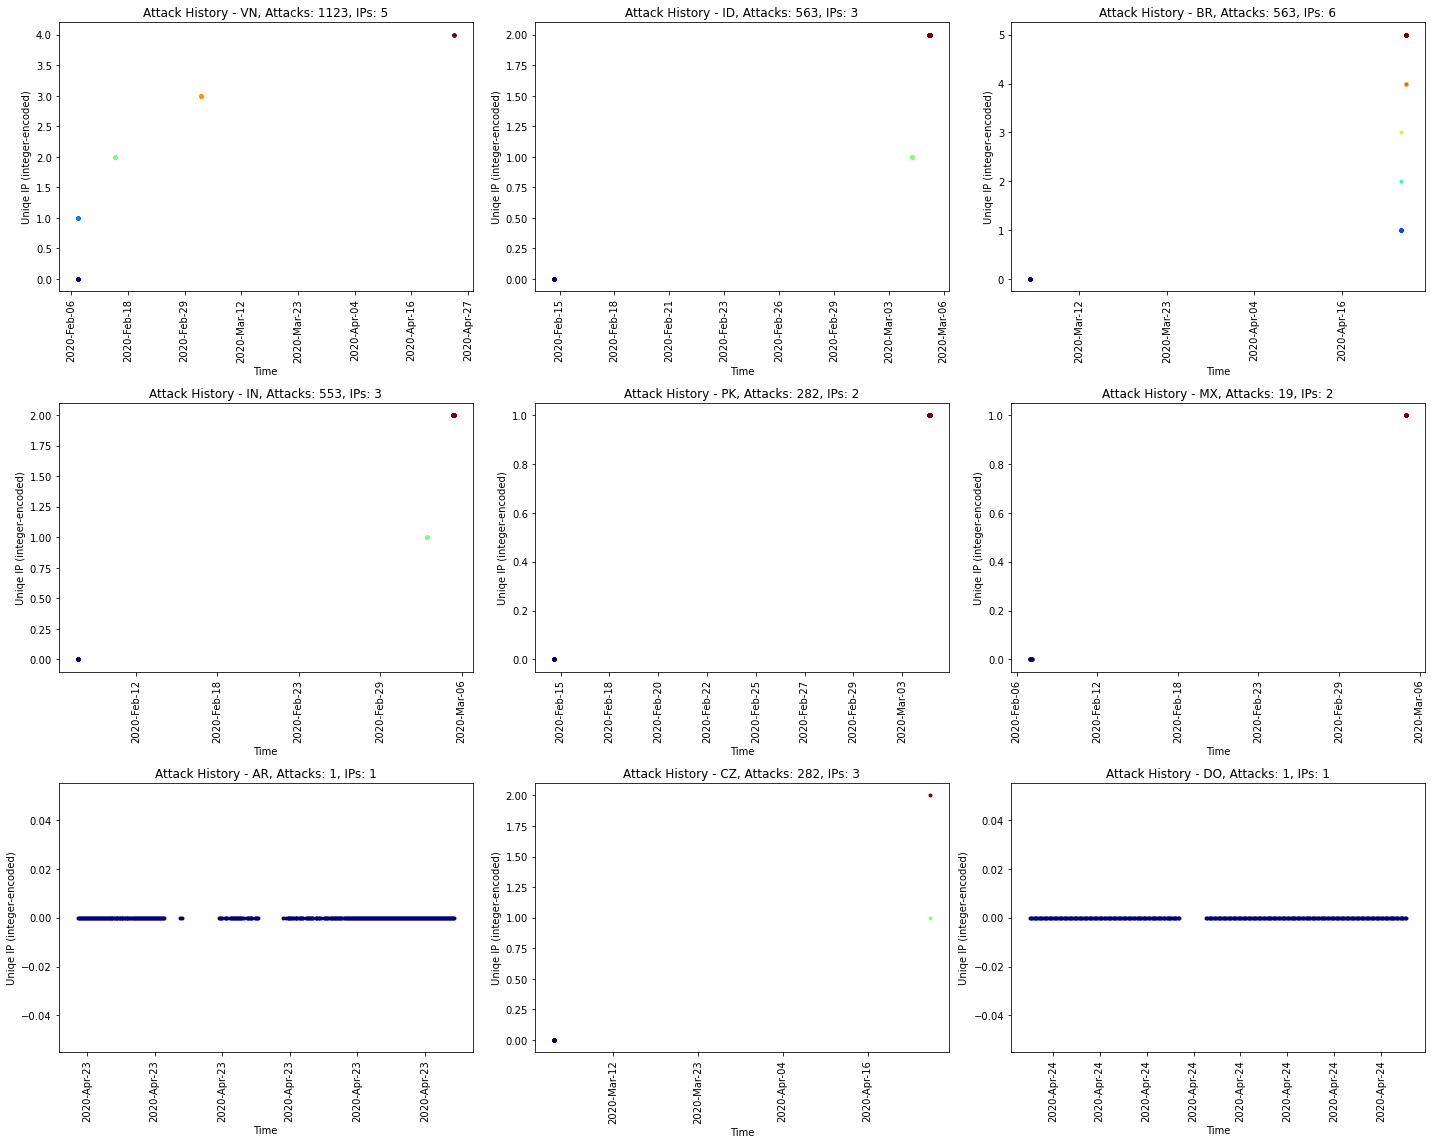

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,16))

for c_i, ax in enumerate(axes.reshape(-1)):
  plt.sca(ax)
  plt_df = fail_df_summary.loc[fail_df_summary['country'] == countries[c_i]]
  num_ips = len(plt_df.index)
  color = mpl.cm.jet(np.linspace(0, 1, len(plt_df)))
  attacks = 0
  for i, row in enumerate(plt_df.sort_values(by='min_unixtime').iterrows()):
    attacks += len(plt_df['unixtime_timeseries'])
    ip_address = row[0]
    plt_df = row[1]
    timeseries = plt_df['unixtime_timeseries']

    plt.scatter(
      timeseries,
      np.full(shape=(len(timeseries),), fill_value=i),
      label=ip_address,
      marker='.',
      color=color[i],
    )
    plt.xticks(rotation='90')
  
  ax.xaxis.set_major_formatter(major_formatter)
  ax.set_ylabel("Uniqe IP (integer-encoded)")
  ax.set_xlabel("Time")
  plt.title("Attack History - {}, Attacks: {}, IPs: {}".format(countries[c_i], attacks, num_ips))
plt.tight_layout()
plt.savefig("attacks.png")

In [63]:
fail_df_summary[fail_df_summary.country == 'VN']

,num_destination_ports_scanned,max_timestamp,min_timestamp,number_of_attempts,uname_count,timeseries,min_unixtime,max_unixtime,unixtime_timeseries,ats,country
source_ip,,,,,,,,,,,
113.190.75.13,5,2020-04-24 16:12:58,2020-04-24 16:12:27,5,1,"[2020-04-24 16:12:27, 2020-04-24 16:12:35, 202...",1.587745e+09,1.587745e+09,"[1587744747.0, 1587744755.0, 1587744763.0, 158...",0.161290,VN
115.75.65.78,278,2020-03-04 01:09:53,2020-03-04 00:33:06,280,14,"[2020-03-04 00:33:06, 2020-03-04 00:33:13, 202...",1.583282e+09,1.583284e+09,"[1583281986.0, 1583281993.0, 1583282001.0, 158...",0.126869,VN
117.5.147.61,280,2020-02-15 11:30:17,2020-02-15 10:33:50,280,14,"[2020-02-15 10:33:50, 2020-02-15 10:34:03, 202...",1.581763e+09,1.581766e+09,"[1581762830.0, 1581762843.0, 1581762856.0, 158...",0.082669,VN
123.24.176.118,280,2020-02-07 23:42:08,2020-02-07 23:03:22,280,14,"[2020-02-07 23:03:22, 2020-02-07 23:03:30, 202...",1.581117e+09,1.581119e+09,"[1581116602.0, 1581116610.0, 1581116618.0, 158...",0.120378,VN
14.177.236.202,277,2020-02-07 22:46:18,2020-02-07 22:03:42,278,14,"[2020-02-07 22:03:42, 2020-02-07 22:03:50, 202...",1.581113e+09,1.581116e+09,"[1581113022.0, 1581113030.0, 1581113041.0, 158...",0.108764,VN


In [67]:
fail_df[fail_df['source_ip'] == "201.212.210.194"]

,timestamp,hostname,auth_source,message,auth_type,auth_pid,message_type,source_ip,user_attempt,destination_port,unixtime
224,2020-04-23 18:18:52,computer,ssh,Invalid user admin from 201.212.210.194 port 5...,ssh,84638,Invalid user,201.212.210.194,admin,51022,1.587666e+09
226,2020-04-23 18:18:59,computer,ssh,Invalid user admin from 201.212.210.194 port 5...,ssh,84640,Invalid user,201.212.210.194,admin,51740,1.587666e+09
228,2020-04-23 18:19:07,computer,ssh,Invalid user admin from 201.212.210.194 port 5...,ssh,84647,Invalid user,201.212.210.194,admin,52621,1.587666e+09
230,2020-04-23 18:19:14,computer,ssh,Invalid user admin from 201.212.210.194 port 5...,ssh,85431,Invalid user,201.212.210.194,admin,53401,1.587666e+09
232,2020-04-23 18:19:22,computer,ssh,Invalid user admin from 201.212.210.194 port 5...,ssh,85434,Invalid user,201.212.210.194,admin,54281,1.587666e+09
...,...,...,...,...,...,...,...,...,...,...,...
831,2020-04-23 19:04:44,computer,ssh,Invalid user telecomadmin from 201.212.210.194...,ssh,87090,Invalid user,201.212.210.194,telecomadmin,52688,1.587669e+09
833,2020-04-23 19:04:51,computer,ssh,Invalid user telecomadmin from 201.212.210.194...,ssh,87093,Invalid user,201.212.210.194,telecomadmin,53631,1.587669e+09
838,2020-04-23 19:04:58,computer,ssh,Invalid user telecomadmin from 201.212.210.194...,ssh,87099,Invalid user,201.212.210.194,telecomadmin,54311,1.587669e+09
840,2020-04-23 19:05:06,computer,ssh,Invalid user telecomadmin from 201.212.210.194...,ssh,87111,Invalid user,201.212.210.194,telecomadmin,55089,1.587669e+09


In [66]:
fail_df_summary[fail_df_summary.country == 'AR']

,num_destination_ports_scanned,max_timestamp,min_timestamp,number_of_attempts,uname_count,timeseries,min_unixtime,max_unixtime,unixtime_timeseries,ats,country
source_ip,,,,,,,,,,,
201.212.210.194,276,2020-04-23 19:05:13,2020-04-23 18:18:52,280,14,"[2020-04-23 18:18:52, 2020-04-23 18:18:59, 202...",1.587666e+09,1.587669e+09,"[1587665932.0, 1587665939.0, 1587665947.0, 158...",0.100683,AR
